In [48]:
%load_ext autoreload
%autoreload 2
from astropy import units as u
from astropy import constants as const
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(70, 0.3)

import iqbal_agn_heating_functions as iq
from cluster_measurements import ClusterMeasurements

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
Mvir = 6*10**14*u.Msun
z=0

In [4]:
Rvir = iq.virial_radius(Mvir, z)
Rvir

<Quantity 2.18375367 Mpc>

In [5]:
from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(70, 0.3)

In [6]:
cvir = iq.c_vir(Mvir, z)
cvir

<Quantity 5.09061079>

In [7]:
r_s = iq.scale_radius(Mvir, z)
r_s

<Quantity 0.42897675 Mpc>

In [8]:
iq.calculate_density_normalization(r_s, Mvir, Rvir)

<Quantity 6.22945048e+14 solMass / Mpc3>

In [9]:
def delta_c(overdensity_constant, concentration):
    return overdensity_constant/3 * concentration**3 / (np.log(1+concentration) - concentration/(1+concentration))

In [10]:
overdensity_const = iq.overdensity(z)
concentration = iq.c_vir(Mvir, z)
dc = delta_c(overdensity_const, concentration)

In [11]:
critical_density = (3*cosmo.H(z)**2/(8*np.pi*const.G)).to(u.g/u.cm**3)
(critical_density * dc).to(u.Msun/u.Mpc**3)

<Quantity 6.22945048e+14 solMass / Mpc3>

In [12]:
def rho_s(z, concentration):
    overdensity_const = iq.overdensity(z)
    dc = delta_c(overdensity_const, concentration)
    critical_density = (3*cosmo.H(z)**2/(8*np.pi*const.G)).to(u.g/u.cm**3)
    return (critical_density * dc).to(u.Msun/u.Mpc**3)

In [13]:
rho_s(0, 1.09) 

<Quantity 2.75356151e+13 solMass / Mpc3>

In [14]:
Rvir/cvir

<Quantity 0.42897675 Mpc>

In [15]:
0.5*u.Mpc/1.09

<Quantity 0.4587156 Mpc>

In [16]:
r500_approx = Rvir/cvir*1.09

In [17]:
r500_approx

<Quantity 0.46758466 Mpc>

In [18]:
Rvir

<Quantity 2.18375367 Mpc>

In [19]:
m500_approx = 4/3 * np.pi * r500_approx**3 * 500 * critical_density
m500_approx.to(u.Msun)

<Quantity 2.9117612e+13 solMass>

In [20]:
mvir_approx = 4/3*np.pi*Rvir**3 * iq.overdensity(z)*critical_density
mvir_approx.to(u.Msun)

<Quantity 6.e+14 solMass>

In [21]:
Rvir

<Quantity 2.18375367 Mpc>

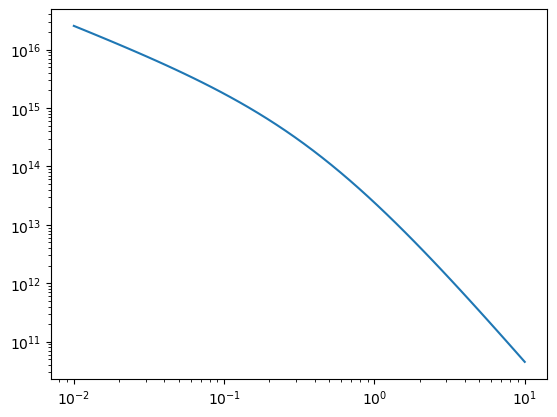

In [22]:
r = np.logspace(-2, 1)*u.Mpc
measurements=ClusterMeasurements(1*u.Mpc, 6*u.Msun*1e14/1.25, 0)
plt.loglog(r, iq.rho_nfw(r, measurements))

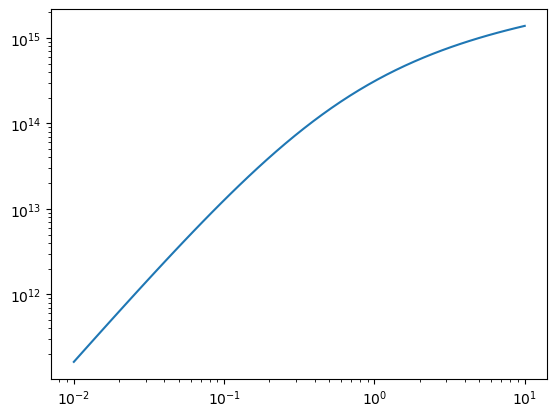

In [23]:
plt.loglog(r, iq.M_enc(r, measurements))

Text(0, 0.5, '(Msun/Mpc3)')

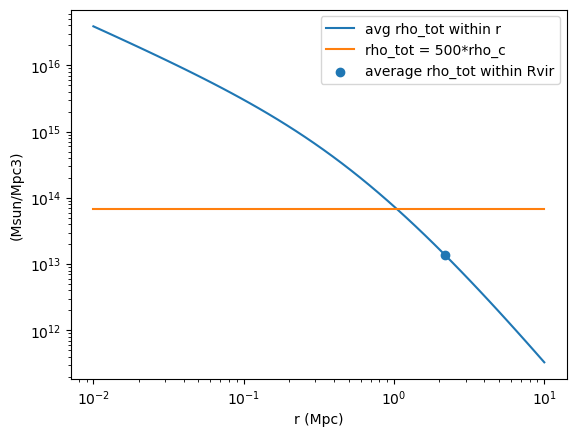

In [24]:
plt.loglog(r, iq.M_enc(r, measurements)/(4/3*np.pi*r**3), label="avg rho_tot within r")

plt.plot([1e-2, 1e1], [500*critical_density.to(u.Msun/u.Mpc**3).value, 500*critical_density.to(u.Msun/u.Mpc**3).value], label="rho_tot = 500*rho_c")

#plt.scatter(1, 500*critical_density.to(u.Msun/u.Mpc**3).value)
plt.scatter(Rvir, Mvir/(4/3*np.pi*Rvir**3), label="average rho_tot within Rvir")
plt.legend()
plt.xlabel("r (Mpc)")
plt.ylabel("(Msun/Mpc3)")

In [25]:
500*critical_density.to(u.Msun/u.Mpc**3)*4/3*np.pi*1*u.Mpc**3

<Quantity 2.84822963e+14 solMass>

In [26]:
def M_enc(r, Mvir, z):
    if isinstance(r, float):
        r=r*u.Mpc
    r_s = iq.scale_radius(Mvir, z)
    Rvir = iq.virial_radius(Mvir, z)
    critical_density = (3*cosmo.H(z)**2/(8*np.pi*const.G)).to(u.g/u.cm**3)
    dc = delta_c(iq.overdensity(z), iq.c_vir(Mvir, z))
    rho_s = (dc*critical_density).to(u.Msun/u.Mpc**3)
    y = r/r_s
    return ((4 * np.pi * r_s**3 * rho_s) * (np.log(1+y) - (y/(1+y)))).to(u.Msun)

In [27]:
from scipy.optimize import brentq
def R500(Mvir, z):
    critical_density = (3*cosmo.H(z)**2/(8*np.pi*const.G)).to(u.g/u.cm**3)
    rho_avg = lambda x: M_enc(x, Mvir, z).value/(4/3*np.pi * x**3) - 500*(critical_density).to(u.Msun/u.Mpc**3).value
    Rvir = iq.virial_radius(Mvir, z).to(u.Mpc)
    r500 = brentq(rho_avg, 0.1*Rvir.value, Rvir.value)
    return r500*u.Mpc
    
    

In [28]:
r500 = R500(6*u.Msun*1e14, 0)
r500

<Quantity 1.04439469 Mpc>

In [29]:
m500 = M_enc(r500, 6*u.Msun*1e14, 0)
m500

<Quantity 3.24465824e+14 solMass>

In [30]:
measurements_6M = ClusterMeasurements(r500, m500, 0)

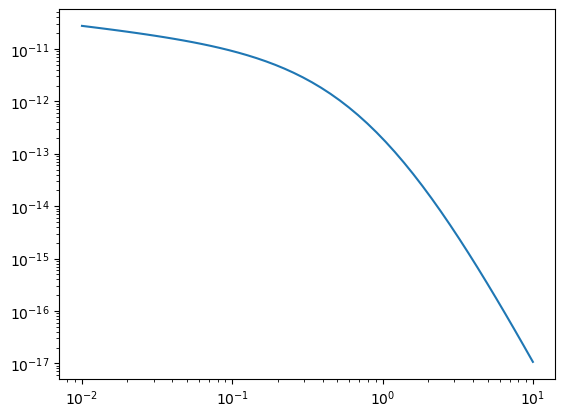

In [31]:
xs = np.logspace(-2, 1)
plt.loglog(xs, iq.Pg(xs, measurements_6M))

In [32]:
from iq_agn_heating_2 import NFWProfile

In [33]:
M6e14_profile = NFWProfile(6*u.Msun*1e14, 0)

In [34]:
M6e14_profile.cvir

<Quantity 5.09061079>

In [35]:
M6e14_profile.M_enc(M6e14_profile.Rvir)

<Quantity 6.e+14 solMass>

In [36]:
M6e14_profile.R500

<Quantity 1.04439469 Mpc>

In [37]:
M6e14_profile.P500()

<Quantity 1.03078595e-12 erg / cm3>

In [38]:
M6e14_profile.T_g(np.logspace(-2,1))

<Quantity [1.23674552e-06, 1.39247168e-06, 1.56290605e-06, 1.74808035e-06,
           1.94761188e-06, 2.16062665e-06, 2.38566788e-06, 2.62063961e-06,
           2.86276986e-06, 3.10861061e-06, 3.35408814e-06, 3.59460757e-06,
           3.82520340e-06, 4.04074643e-06, 4.23617446e-06, 4.40674616e-06,
           4.54828507e-06, 4.65739693e-06, 4.73164289e-06, 4.76964991e-06,
           4.77116158e-06, 4.73701737e-06, 4.66907441e-06, 4.57007615e-06,
           4.44347895e-06, 4.29325675e-06, 4.12369418e-06, 3.93917621e-06,
           3.74400288e-06, 3.54222283e-06, 3.33750627e-06, 3.13305586e-06,
           2.93155748e-06, 2.73516943e-06, 2.54554169e-06, 2.36386100e-06,
           2.19090891e-06, 2.02712978e-06, 1.87269851e-06, 1.72758420e-06,
           1.59160596e-06, 1.46448016e-06, 1.34585759e-06, 1.23535141e-06,
           1.13255782e-06, 1.03706975e-06, 9.48485786e-07, 8.66415407e-07,
           7.90481702e-07, 7.20322269e-07] GeV>

In [87]:
heating_03 = M6e14_profile.vol_heating_rate(np.logspace(-2,1)*u.Mpc, 2e45*u.erg/u.s, 0.3*M6e14_profile.R500)

In [88]:
heating_01 = M6e14_profile.vol_heating_rate(np.logspace(-2,1)*u.Mpc, 2e45*u.erg/u.s, 0.1*M6e14_profile.R500)

In [89]:
cooling_6e14 = M6e14_profile.vol_cooling_rate(rs)

In [90]:
rs = np.logspace(-2,1)*u.Mpc

In [106]:
rs

<Quantity [ 0.01      ,  0.01151395,  0.01325711,  0.01526418,  0.01757511,
            0.0202359 ,  0.02329952,  0.02682696,  0.03088844,  0.0355648 ,
            0.04094915,  0.04714866,  0.05428675,  0.06250552,  0.07196857,
            0.08286428,  0.09540955,  0.10985411,  0.12648552,  0.14563485,
            0.16768329,  0.19306977,  0.22229965,  0.25595479,  0.29470517,
            0.33932218,  0.39069399,  0.44984327,  0.51794747,  0.59636233,
            0.68664885,  0.79060432,  0.91029818,  1.04811313,  1.20679264,
            1.38949549,  1.59985872,  1.84206997,  2.12095089,  2.44205309,
            2.8117687 ,  3.23745754,  3.72759372,  4.29193426,  4.94171336,
            5.68986603,  6.55128557,  7.54312006,  8.68511374, 10.        ] Mpc>

0.01 Mpc
[0.01] Mpc
0.011513953993264475 Mpc
[0.01151395] Mpc
0.013257113655901088 Mpc
[0.01325711] Mpc
0.015264179671752334 Mpc
[0.01526418] Mpc
0.017575106248547922 Mpc
[0.01757511] Mpc
0.020235896477251575 Mpc
[0.0202359] Mpc
0.023299518105153717 Mpc
[0.02329952] Mpc
0.02682695795279726 Mpc
[0.02682696] Mpc
0.030888435964774818 Mpc
[0.03088844] Mpc
0.03556480306223128 Mpc
[0.0355648] Mpc
0.040949150623804255 Mpc
[0.04094915] Mpc
0.04714866363457394 Mpc
[0.04714866] Mpc
0.054286754393238594 Mpc
[0.05428675] Mpc
0.06250551925273973 Mpc
[0.06250552] Mpc
0.07196856730011521 Mpc
[0.07196857] Mpc
0.08286427728546843 Mpc
[0.08286428] Mpc
0.09540954763499938 Mpc
[0.09540955] Mpc
0.10985411419875583 Mpc
[0.10985412] Mpc
0.12648552168552957 Mpc
[0.12648552] Mpc
0.14563484775012436 Mpc
[0.14563485] Mpc
0.16768329368110083 Mpc
[0.1676833] Mpc
0.19306977288832497 Mpc
[0.19306977] Mpc
0.22229964825261944 Mpc
[0.22229965] Mpc
0.2559547922699536 Mpc
[0.25595479] Mpc
0.29470517025518095 Mpc
[0.29470

Text(0, 0.5, 'heating/cooling rate, erg/s*cm3')

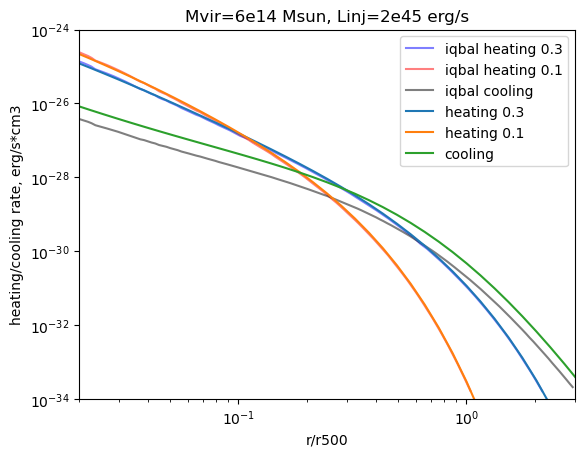

In [105]:
iq_heating_03 = pd.read_csv('data/iqbal_heating_03_6e14.csv', header=None)
iq_heating_01 = pd.read_csv('data/iqbal_heating_01_6e14.csv', header=None)
iq_cooling = pd.read_csv('data/iqbal_cooling_6e14.csv', header=None)
plt.loglog(iq_heating_03[0], iq_heating_03[1], color="blue", alpha=0.5, label="iqbal heating 0.3" )
plt.loglog(iq_heating_01[0], iq_heating_01[1], color="red", alpha=0.5, label="iqbal heating 0.1")
plt.loglog(iq_cooling[0], iq_cooling[1], color="black", alpha=0.5, label="iqbal cooling")


plt.loglog(np.logspace(-2,1)*u.Mpc/M6e14_profile.R500, heating_03, label="heating 0.3")
plt.loglog(np.logspace(-2,1)*u.Mpc/M6e14_profile.R500, heating_01, label="heating 0.1")
plt.loglog(rs/M6e14_profile.R500, M6e14_profile.vol_cooling_rate(rs), label="cooling")
plt.xlim(2e-2, 3)
plt.ylim(1e-34, 1e-24)
plt.legend()
plt.title("Mvir=6e14 Msun, Linj=2e45 erg/s")
plt.xlabel("r/r500")
plt.ylabel("heating/cooling rate, erg/s*cm3")

In [92]:
M2e14_profile = NFWProfile(2*u.Msun*1e14, 0)

In [93]:
heating_03_2e14 = M2e14_profile.vol_heating_rate(np.logspace(-2,1)*u.Mpc, 7e44*u.erg/u.s, 0.3*M2e14_profile.R500)

In [94]:
heating_01_2e14 = M2e14_profile.vol_heating_rate(np.logspace(-2,1)*u.Mpc, 7e44*u.erg/u.s, 0.1*M2e14_profile.R500)

Text(0.5, 1.0, 'Mvir=2e14 Msun, Linj=7e44 erg/s')

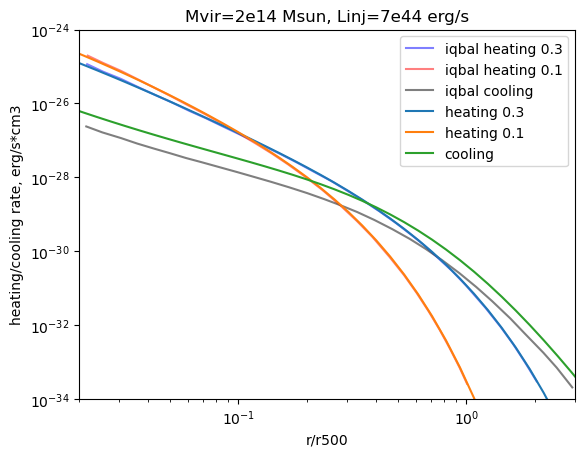

In [95]:

iq_heating_03 = pd.read_csv('data/iqbal_heating_03.csv', header=None)
iq_heating_01 = pd.read_csv('data/iqbal_heating_01.csv', header=None)
iq_cooling = pd.read_csv('data/iqbal_cooling.csv', header=None)
plt.loglog(iq_heating_03[0], iq_heating_03[1], color="blue", alpha=0.5, label="iqbal heating 0.3" )
plt.loglog(iq_heating_01[0], iq_heating_01[1], color="red", alpha=0.5, label="iqbal heating 0.1")
plt.loglog(iq_cooling[0], iq_cooling[1], color="black", alpha=0.5, label="iqbal cooling")


plt.loglog(np.logspace(-2,1)*u.Mpc/M2e14_profile.R500, heating_03_2e14, label="heating 0.3")
plt.loglog(np.logspace(-2,1)*u.Mpc/M2e14_profile.R500, heating_01_2e14, label="heating 0.1")
plt.loglog(rs/M2e14_profile.R500, M2e14_profile.vol_cooling_rate(rs), label="cooling")
plt.xlim(2e-2, 3)
plt.ylim(1e-34, 1e-24)
plt.xlabel("r/r500")
plt.ylabel("heating/cooling rate, erg/s*cm3")
plt.legend()
plt.title("Mvir=2e14 Msun, Linj=7e44 erg/s")

In [96]:
M2e15_profile = NFWProfile(2*u.Msun*1e15, 0)

In [97]:
heating_03_2e15 = M2e15_profile.vol_heating_rate(np.logspace(-2,1)*u.Mpc, 5e45*u.erg/u.s, 0.3*M2e15_profile.R500)
heating_01_2e15 = M2e15_profile.vol_heating_rate(np.logspace(-2,1)*u.Mpc, 5e45*u.erg/u.s, 0.1*M2e15_profile.R500)

Text(0.5, 1.0, 'Mvir=2e15 Msun, Linj=5e45 erg/s')

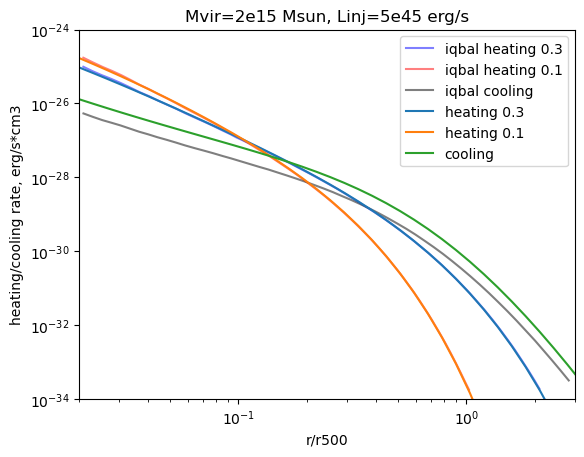

In [98]:
iq_heating_03 = pd.read_csv('data/iqbal_heating_2e15_03.csv', header=None)
iq_heating_01 = pd.read_csv('data/iqbal_heating_2e15_01.csv', header=None)
iq_cooling = pd.read_csv('data/iqbal_cooling_2e15.csv', header=None)
plt.loglog(iq_heating_03[0], iq_heating_03[1], color="blue", alpha=0.5, label="iqbal heating 0.3" )
plt.loglog(iq_heating_01[0], iq_heating_01[1], color="red", alpha=0.5, label="iqbal heating 0.1")
plt.loglog(iq_cooling[0], iq_cooling[1], color="black", alpha=0.5, label="iqbal cooling")



plt.loglog(np.logspace(-2,1)*u.Mpc/M2e15_profile.R500, heating_03_2e15, label="heating 0.3")
plt.loglog(np.logspace(-2,1)*u.Mpc/M2e15_profile.R500, heating_01_2e15, label="heating 0.1")
plt.loglog(rs/M2e15_profile.R500, M2e15_profile.vol_cooling_rate(rs), label="cooling")
plt.xlim(2e-2, 3)
plt.ylim(1e-34, 1e-24)
plt.xlabel("r/r500")
plt.ylabel("heating/cooling rate, erg/s*cm3")
plt.legend()
plt.title("Mvir=2e15 Msun, Linj=5e45 erg/s")

Text(0.5, 1.0, 'from fig 2, Mvir=6e14 Msun, z=0')

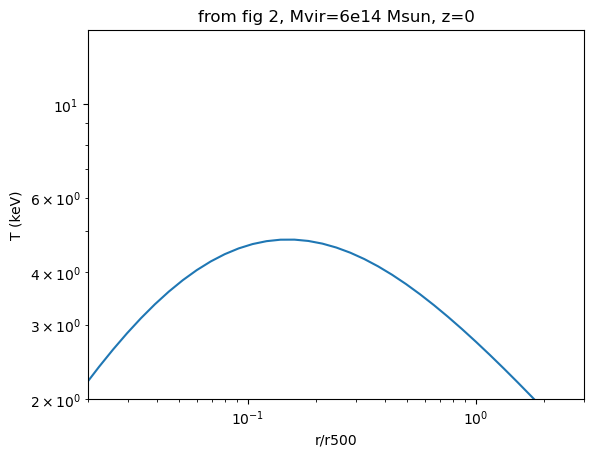

In [99]:
plt.loglog(rs/M6e14_profile.R500, M6e14_profile.T_g(rs.value).to(u.keV))
plt.xlim(2e-2, 3)
plt.ylim(2, 15)
plt.xlabel("r/r500")
plt.ylabel("T (keV)")
plt.title("from fig 2, Mvir=6e14 Msun, z=0")

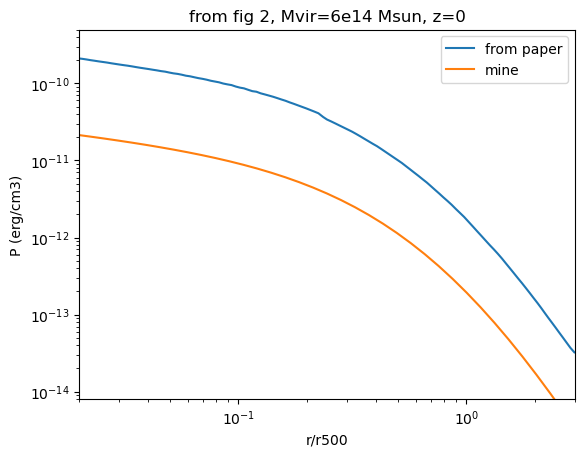

In [54]:
iq_pressure = pd.read_csv('data/iqbal_pressure.csv', header=None)
plt.loglog(iq_pressure[0], iq_pressure[1], label="from paper")

plt.loglog(rs/M6e14_profile.R500, M6e14_profile.Pg(rs/M6e14_profile.R500), label="mine")
plt.xlim(2e-2, 3)
plt.ylim(8e-15, 5e-10)
plt.xlabel("r/r500")
plt.ylabel("P (erg/cm3)")
plt.title("from fig 2, Mvir=6e14 Msun, z=0")
plt.legend()

In [62]:
M6e14_profile.P500()

<Quantity 1.03078595e-12 erg / cm3>

In [102]:
M6e14_profile.P500_planelles()

<Quantity 8.52299651e-12 erg / cm3>

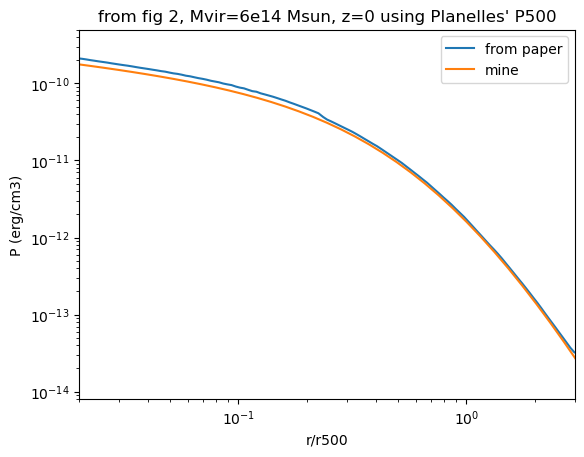

In [103]:
#RERAN BUT WITH P500=P500_planelles
iq_pressure = pd.read_csv('data/iqbal_pressure.csv', header=None)
plt.loglog(iq_pressure[0], iq_pressure[1], label="from paper")

plt.loglog(rs/M6e14_profile.R500, M6e14_profile.Pg(rs/M6e14_profile.R500), label="mine")
plt.xlim(2e-2, 3)
plt.ylim(8e-15, 5e-10)
plt.xlabel("r/r500")
plt.ylabel("P (erg/cm3)")
plt.title("from fig 2, Mvir=6e14 Msun, z=0 using Planelles' P500")
plt.legend()

Text(0.5, 1.0, 'comparison of dP/dr')

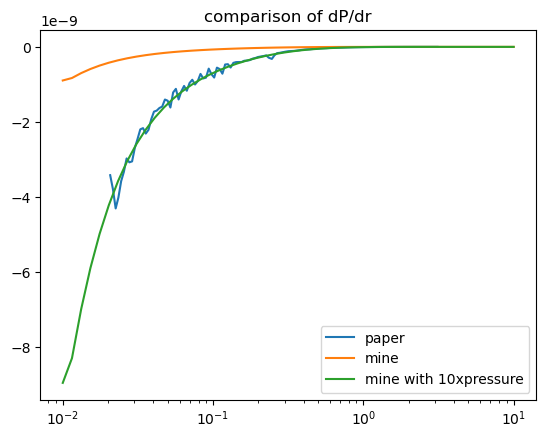

In [55]:
plt.plot(iq_pressure[0]*M6e14_profile.R500, np.gradient(iq_pressure[1],iq_pressure[0]*M6e14_profile.R500), label="paper")
plt.plot(rs, np.gradient(M6e14_profile.Pg(rs/M6e14_profile.R500),rs), label="mine")
plt.plot(rs, np.gradient(10*M6e14_profile.Pg(rs/M6e14_profile.R500),rs), label="mine with 10xpressure")
plt.legend()
plt.xscale('log')
plt.title("comparison of dP/dr")

Text(0.5, 1.0, "comparison of dP/dr with Planelles' P500")

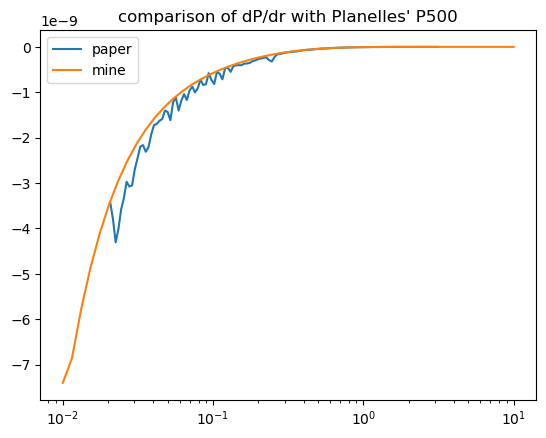

In [68]:
# RERAN WITH P500_planelles
plt.plot(iq_pressure[0]*M6e14_profile.R500, np.gradient(iq_pressure[1],iq_pressure[0]*M6e14_profile.R500), label="paper")
plt.plot(rs, np.gradient(M6e14_profile.Pg(rs/M6e14_profile.R500),rs), label="mine")
plt.legend()
plt.xscale('log')
plt.title("comparison of dP/dr with Planelles' P500")

In [104]:
np.gradient(M6e14_profile.Pg(rs/M6e14_profile.R500),rs)

<Quantity [-7.40200170e-09, -6.85815693e-09, -5.77790508e-09,
           -4.87564086e-09, -4.12131975e-09, -3.48995287e-09,
           -2.96075585e-09, -2.51644187e-09, -2.14263469e-09,
           -1.82738160e-09, -1.56074966e-09, -1.33449128e-09,
           -1.14176739e-09, -9.76918793e-10, -8.35276997e-10,
           -7.13007849e-10, -6.06981549e-10, -5.14663742e-10,
           -4.34022811e-10, -3.63449069e-10, -3.01682178e-10,
           -2.47743874e-10, -2.00874110e-10, -1.60470024e-10,
           -1.26028613e-10, -9.70953954e-11, -7.32223627e-11,
           -5.39386720e-11, -3.87366227e-11, -2.70734439e-11,
           -1.83867732e-11, -1.21191869e-11, -7.74561694e-12,
           -4.79752219e-12, -2.87926671e-12, -1.67470244e-12,
           -9.44552161e-13, -5.17047599e-13, -2.75017012e-13,
           -1.42339153e-13, -7.17986334e-14, -3.53575544e-14,
           -1.70295389e-14, -8.03657026e-15, -3.72282225e-15,
           -1.69579350e-15, -7.60860947e-16, -3.36790944e-16,
        

Text(0.5, 1.0, '6e14 Msun')

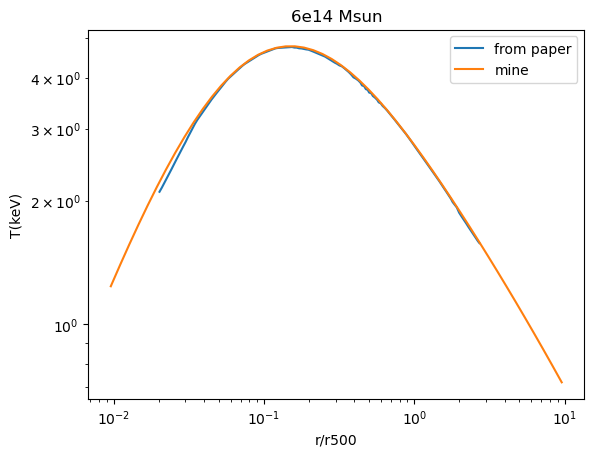

In [69]:
iq_temp = pd.read_csv('data/iqbal_temperature.csv', header=None)
plt.loglog(iq_temp[0], iq_temp[1], label="from paper")

plt.loglog(rs/M6e14_profile.R500, M6e14_profile.T_g(rs.value).to(u.keV), label="mine")

plt.xlabel('r/r500')
plt.ylabel('T(keV)')
plt.legend()
plt.title("6e14 Msun")

In [1]:
iq_heating_03 = pd.read_csv('data/iqbal_heating_03_6e14.csv', header=None)
iq_heating_01 = pd.read_csv('data/iqbal_heating_01_6e14.csv', header=None)
iq_cooling = pd.read_csv('data/iqbal_cooling_6e14.csv', header=None)
plt.loglog(iq_heating_03[0], iq_heating_03[1], color="blue", alpha=0.5, label="iqbal heating 0.3" )
plt.loglog(iq_heating_01[0], iq_heating_01[1], color="red", alpha=0.5, label="iqbal heating 0.1")
plt.loglog(iq_cooling[0], iq_cooling[1], color="black", alpha=0.5, label="iqbal cooling")


plt.loglog(np.logspace(-2,1)*u.Mpc/M6e14_profile.R500, heating_03, label="heating 0.3")
plt.loglog(np.logspace(-2,1)*u.Mpc/M6e14_profile.R500, heating_01, label="heating 0.1")
plt.loglog(rs/M6e14_profile.R500, M6e14_profile.vol_cooling_rate(rs), label="cooling")
plt.xlim(2e-2, 3)
plt.ylim(1e-34, 1e-24)
plt.legend()
plt.title("Mvir=6e14 Msun, Linj=2e45 erg/s, P->10*P")
plt.xlabel("r/r500")
plt.ylabel("heating/cooling rate, erg/s*cm3")

NameError: name 'pd' is not defined

NameError: name 'nfws' is not defined